In [1]:
import os
import joblib
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import importlib
sys.path.append("..")
import src.utils.load_data_utils
importlib.reload(src.utils.load_data_utils)
from src.utils.load_data_utils import get_data

In [2]:
# read files
root_folder = "../results_eval_tune"
files = os.listdir(root_folder)

# set filter
files = [s for s in files if "xgb" in s and "Jul-20" in s]

In [3]:
model_dict = {}

for file in files:
    eval_tuning_path = join(root_folder, file)
    study_list =  os.listdir(eval_tuning_path)
    study_list = [study for study in study_list if study.endswith(".pkl") and study != "cfg.pkl"]
    if len(study_list) != 10:
        continue
    print(file, len(study_list))

    names = ["hyperparams", "eval_score", "score_dict", "y_pred_logits", "y_pred_binary", "y_true"]
    models = [joblib.load(join(eval_tuning_path, study))[-1] for study in study_list]
    model_dict[file] = models
    # print hyperparams:
    if "opt" in file:
        for study in study_list:
            hypers = joblib.load(join(eval_tuning_path, study))[0]
            print(hypers["df"])

Jul-20-02:29:14_xgb_0k_freeze_10_5_clinical 10


In [4]:
feat_imp_dict = {}
for key in model_dict:
    if isinstance(model_dict[key][0], np.ndarray):
        continue
    print(key)
    feat_imp_dict[key] = [model.feature_importances_ for model in model_dict[key]]

Jul-20-02:29:14_xgb_0k_freeze_10_5_clinical


In [5]:
for key in feat_imp_dict:
    print(key)
    mean_feats = np.mean(feat_imp_dict[key], axis=0)
    std_feats = np.std(feat_imp_dict[key], axis=0)

    print(mean_feats.sum())

Jul-20-02:29:14_xgb_0k_freeze_10_5_clinical
1.0


In [6]:
for key in feat_imp_dict:
    num_feats_key = feat_imp_dict[key][0].shape[0]
    print(key)
    print(num_feats_key)
    print()
    assert num_feats_key > 4, f'{key}, {num_feats_key}'

Jul-20-02:29:14_xgb_0k_freeze_10_5_clinical
7



In [39]:
# MAKE CHANGES HERE!!
#dts = ["clinical", "blood", "sparse_img"]
dts = ["clinical"]
round_number = 3
# setting the reduction threshold to 0.0 will not remove any features.
# the higher, the more features are removed. I suggest 0.1-0.5.
reduction_threshold = 0.1

In [40]:
all_dts = ["clinical", "blood", "imaging_pca", "sparse_img"]
features = None if round_number == 0 else f"clinical_round{round_number}_rfe_feats.pkl"

In [41]:
df = "yeo_Y/z/median/uni_clip_0.9999/multi_clip_N"
x_train, y_train, x_eval, y_eval, n_features, feature_names, class_weights = get_data(df_name=df, split='no-split', nf=0, v=0,
             blood=("blood" in dts), static=1, clinical=("clinical" in dts), imaging=0, imaging_pca=("imaging" in dts), miss_feats=0,
             sparse_img=("sparse_img" in dts),
             features=features
             )

In [42]:
data_first = x_train[0]
data_len = len(data_first)
print("Num feats: ", data_first.shape[1])
print("All:", data_len, "Dev:", int(data_len * 0.8), "Test", int(data_len * 0.2))
print("Train split size: ", int(data_len * 0.8 * 0.9), "Val split size: ", int(data_len * 0.8 * 0.1))

Num feats:  7
All: 929 Dev: 743 Test 185
Train split size:  668 Val split size:  74


In [43]:
study_name = [key for key in feat_imp_dict if all([dt in key for dt in dts]) and not any([dt in key for dt in [other_dt for other_dt in all_dts if other_dt not in dts]])]
study_name = study_name[0]
study_name
feat_imps = feat_imp_dict[study_name]

In [44]:
len(feature_names)

7

In [45]:
feat_imp_dict[study_name][0].shape[0]

7

In [46]:
assert len(feature_names) == feat_imp_dict[study_name][0].shape[0], "feature quantity of loaded data and model do not match - make sure that 'dts' is the same here as in the trained model"

In [47]:
rename = True
orig_feature_names = feature_names
if rename:
    for dt in all_dts:
        feature_names = [col[len(dt) + 1:] if col.startswith(dt) else col for col in feature_names]
    feature_names = [col.replace("_", " ") for col in feature_names]
    feature_names = [col.replace(" nan", " - Missingness Feature") for col in feature_names]
    feature_names = [col[0].upper() + col[1:] for col in feature_names]

    feature_names = [col[9:] if "clinical" in col else col for col in feature_names]
    feature_names = [col[6:] if "blood" in col else col for col in feature_names]

In [48]:
df = pd.DataFrame({"mean_val": np.array(feat_imps).mean(0), "feat_names": feature_names, "orig_feat_names": orig_feature_names})
df = df.sort_values("mean_val", ascending=True)

In [49]:
#suffix = ""
suffix = f"_round{round_number + 1}_rfe"

7
6
clinical_round4_rfe
Saving to  clinical_round4_rfe.jpg


<ipython-input-50-8410da1f08d9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_df["mean_val"] = mean_df["mean_val"] * 100


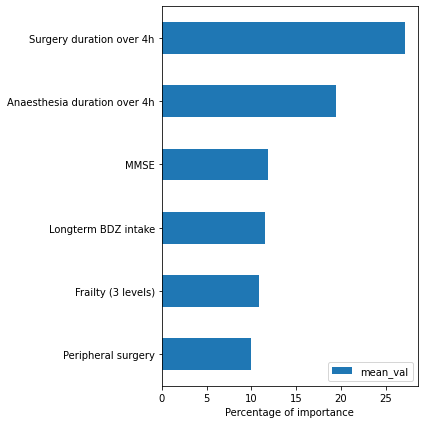

In [50]:
#mean_df = df.mean(axis=0).sort_values(ascending=True)
# remove everything above 90% explained importance
print(len(df))
mean_df = df[df["mean_val"].cumsum() >= reduction_threshold]
print(len(mean_df))
mean_df["mean_val"] = mean_df["mean_val"] * 100
if dts == ["sparse_img"]:
    figsize = (6, 2)
else:
    figsize = (6, 6)

fig = mean_df.plot.barh("feat_names", "mean_val", figsize=figsize)
plt.xlabel("Percentage of importance")
plt.ylabel("")
plt.tight_layout()
name = "_".join(dts) + suffix
print(name)
plt.savefig(name + "importances.jpg")
mean_df.to_csv(name + "importances.csv")
print("Saving to ", name + ".jpg")

In [51]:
# save top p
save_df = mean_df[mean_df["feat_names"] != "Preop. cognitive impairment"]
selected_feats = list(save_df["orig_feat_names"])
print("selected feats: ", selected_feats)
import joblib
joblib.dump(selected_feats, name + "_feats.pkl")

selected feats:  ['clinical_Peripheral surgery', 'clinical_Frailty (3 levels)', 'clinical_longterm BDZ intake', 'clinical_MMSE', 'clinical_Anaesthesia duration over 4h', 'clinical_Surgery duration over 4h']


['clinical_round4_rfe_feats.pkl']